<a href="https://colab.research.google.com/github/fourmodern/targetdiscovery/blob/main/01_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🫁 TCGA 데이터를 활용한 폐암 특이 바이오마커 발굴 및 약물 타겟 검증

---

## 📚 Aim of this Tutorial

본 튜토리얼은 공개된 TCGA (The Cancer Genome Atlas) 데이터를 활용하여 폐암 특이적 바이오마커를 발굴하고, 이를 기반으로 약물 타겟을 검증하는 전체 워크플로우를 제공합니다. 특히 EGFR 변이체와 관련 표적 치료제를 중심으로 실무에 적용 가능한 분석 파이프라인을 구축합니다.

### 🎯 학습 목표
1. cBioPortal API를 통한 TCGA 오믹스 데이터 접근 및 처리
2. 유전자 발현 및 변이 데이터의 통합 분석
3. 통계적 방법을 활용한 폐암 특이 바이오마커 선정
4. Pathway enrichment 분석을 통한 생물학적 기능 해석
5. Therapeutic target database를 활용한 약물 타겟 검증

---

## 📖 Contents in Theory

### 1. **TCGA (The Cancer Genome Atlas)**
- 33개 암종에 대한 대규모 멀티오믹스 데이터
- RNA-seq, DNA methylation, copy number variation, somatic mutations 등 포함
- 표준화된 데이터 처리 파이프라인 적용

### 2. **폐암의 분자생물학적 특성**
- **LUAD (Lung Adenocarcinoma)**: EGFR, KRAS, ALK 변이가 주요 driver
- **LUSC (Lung Squamous Cell Carcinoma)**: TP53, CDKN2A 변이가 흔함
- 표적 치료제 개발이 활발한 암종

### 3. **바이오마커 발굴 전략**
- **차등 발현 분석 (Differential Expression Analysis)**
  - t-test, Wilcoxon rank-sum test
  - 다중 검정 보정 (FDR, Bonferroni)
- **변이 데이터 통합**
  - Driver vs Passenger mutations
  - Actionable mutations 식별

### 4. **Pathway Analysis**
- Over-representation analysis (ORA)
- Gene Set Enrichment Analysis (GSEA)
- Network-based approaches

---

## 🛠️ Contents in Practical

1. **환경 설정 및 데이터 접근**
   - 필요 패키지 설치
   - cBioPortal API 연결
   
2. **TCGA 폐암 데이터 수집**
   - RNA-seq 발현 데이터
   - Somatic mutation 데이터
   - 임상 정보
   
3. **데이터 전처리 및 품질 관리**
   - 발현값 정규화
   - 이상치 제거
   - 데이터 통합
   
4. **바이오마커 선정**
   - 차등 발현 유전자 분석
   - 변이 빈도 분석
   - 발현-변이 통합 분석
   
5. **Pathway 분석**
   - KEGG pathway enrichment
   - Reactome pathway analysis
   - PPI network 구축
   
6. **약물 타겟 검증**
   - DGIdb (Drug Gene Interaction database) 조회
   - TTD (Therapeutic Target Database) 매핑
   - FDA 승인 약물 확인
   
7. **시각화 및 결과 해석**
   - Heatmap, Volcano plot, Oncoplot
   - Network visualization
   - Clinical relevance 평가


## 1. 환경 설정 및 패키지 설치

Google Colab 환경에서 필요한 패키지들을 설치합니다.

In [1]:
# 필요한 패키지 설치 (Google Colab용)
!pip install -q pandas numpy matplotlib seaborn scipy requests plotly scikit-learn
!pip install -q statsmodels lifelines
!pip install -q gseapy  # pathway analysis용

print("✅ 모든 패키지가 설치되었습니다!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 16.1 MB/s eta 0:00:00
✅ 모든 패키지가 설치되었습니다!


In [2]:
# 기본 라이브러리 임포트
import os
import sys
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.stats.multitest as smm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# 랜덤 시드 설정
np.random.seed(42)

print("✅ 환경 설정 완료!")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ 환경 설정 완료!
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Pandas version: 2.2.2
NumPy version: 2.0.2


## 2. TCGA 데이터 접근 및 수집

### 2.1 cBioPortal API를 통한 데이터 접근

cBioPortal은 TCGA를 포함한 다양한 암 유전체 데이터를 제공하는 공개 플랫폼입니다.

In [3]:
# cBioPortal API 기본 설정
CBIOPORTAL_URL = "https://www.cbioportal.org/api"

def get_cancer_studies():
    """사용 가능한 TCGA 암종 연구 목록 조회"""
    url = f"{CBIOPORTAL_URL}/studies"
    response = requests.get(url)
    studies = pd.DataFrame(response.json())

    # TCGA 연구만 필터링
    tcga_studies = studies[studies['studyId'].str.contains('tcga')]
    return tcga_studies

# TCGA 연구 목록 확인
tcga_studies = get_cancer_studies()
print(f"✅ 사용 가능한 TCGA 연구: {len(tcga_studies)}개")

# 폐암 관련 연구 확인
lung_studies = tcga_studies[tcga_studies['name'].str.contains('Lung', case=False)]
print("\n🫁 폐암 관련 TCGA 연구:")
for _, study in lung_studies.iterrows():
    print(f"  - {study['studyId']}: {study['name']} (샘플 수: {study['allSampleCount']})")

✅ 사용 가능한 TCGA 연구: 123개

🫁 폐암 관련 TCGA 연구:
  - luad_tcga_gdc: Lung Adenocarcinoma (TCGA, GDC) (샘플 수: 571)
  - lusc_tcga_gdc: Lung Squamous Cell Carcinoma (TCGA, GDC) (샘플 수: 503)
  - luad_tcga: Lung Adenocarcinoma (TCGA, Firehose Legacy) (샘플 수: 586)
  - lusc_tcga: Lung Squamous Cell Carcinoma (TCGA, Firehose Legacy) (샘플 수: 511)
  - luad_tcga_pub: Lung Adenocarcinoma (TCGA, Nature 2014) (샘플 수: 230)
  - lusc_tcga_pub: Lung Squamous Cell Carcinoma (TCGA, Nature 2012) (샘플 수: 178)
  - nsclc_tcga_broad_2016: Pan-Lung Cancer (TCGA, Nat Genet 2016) (샘플 수: 1144)
  - luad_tcga_pan_can_atlas_2018: Lung Adenocarcinoma (TCGA, PanCancer Atlas) (샘플 수: 566)
  - lusc_tcga_pan_can_atlas_2018: Lung Squamous Cell Carcinoma (TCGA, PanCancer Atlas) (샘플 수: 487)


### 2.2 RNA-seq 발현 데이터 수집

폐암과 관련된 주요 유전자들의 발현 데이터를 수집합니다.

In [4]:
# 분석할 주요 폐암 관련 유전자 목록
TARGET_GENES = [
    "EGFR", "KRAS", "ALK", "ROS1", "BRAF", "MET", "RET", "NTRK1", "NTRK2", "NTRK3",
    "TP53", "STK11", "KEAP1", "PIK3CA", "PTEN", "CDKN2A", "RB1", "ERBB2", "MAP2K1",
    "NF1", "SMARCA4", "ARID1A", "SETD2", "ATM", "BRCA2"
]

def get_gene_expression_data(study_id, genes, max_samples=500):
    """
    특정 연구에서 유전자 발현 데이터 가져오기
    """
    print(f"\n📊 {study_id}에서 유전자 발현 데이터 수집 중...")

    # 1. Molecular Profile 찾기
    profiles_url = f"{CBIOPORTAL_URL}/studies/{study_id}/molecular-profiles"
    profiles = requests.get(profiles_url).json()

    # RNA-seq 프로파일 찾기
    rna_profile = None
    for profile in profiles:
        if "rna_seq" in profile['molecularProfileId'] and "v2" in profile['molecularProfileId']:
            rna_profile = profile['molecularProfileId']
            break

    if not rna_profile:
        print("❌ RNA-seq 프로파일을 찾을 수 없습니다.")
        return None

    print(f"✅ 사용할 molecular profile: {rna_profile}")

    # 2. 유전자 정보 가져오기
    genes_url = f"{CBIOPORTAL_URL}/genes"
    gene_response = requests.get(genes_url, params={"geneIdType": "HUGO_GENE_SYMBOL"})
    all_genes = pd.DataFrame(gene_response.json())

    our_genes = all_genes[all_genes['hugoGeneSymbol'].isin(genes)]
    gene_map = dict(zip(our_genes['hugoGeneSymbol'], our_genes['entrezGeneId']))

    # 3. 발현 데이터 가져오기
    expr_data = []

    for gene, entrez_id in gene_map.items():
        print(f"  - {gene} 데이터 수집 중...", end='')

        expr_url = f"{CBIOPORTAL_URL}/molecular-profiles/{rna_profile}/molecular-data"
        params = {
            "sampleListId": f"{study_id}_all",
            "entrezGeneId": entrez_id
        }

        try:
            response = requests.get(expr_url, params=params)
            if response.status_code == 200:
                data = response.json()
                for item in data[:max_samples]:
                    expr_data.append({
                        'sampleId': item['sampleId'],
                        'patientId': item['patientId'],
                        'gene': gene,
                        'expression': item['value']
                    })
                print(" ✓")
            else:
                print(f" ✗ (오류: {response.status_code})")
        except Exception as e:
            print(f" ✗ (예외: {str(e)})")

    # DataFrame으로 변환
    if expr_data:
        df = pd.DataFrame(expr_data)
        expr_matrix = df.pivot_table(index='sampleId', columns='gene', values='expression')
        print(f"\n✅ 발현 데이터 수집 완료! Shape: {expr_matrix.shape}")
        return expr_matrix
    else:
        print("\n❌ 발현 데이터를 가져올 수 없습니다.")
        return None

# LUAD (Lung Adenocarcinoma) 데이터 가져오기
luad_expr = get_gene_expression_data("luad_tcga_pan_can_atlas_2018", TARGET_GENES)

# LUSC (Lung Squamous Cell Carcinoma) 데이터 가져오기
lusc_expr = get_gene_expression_data("lusc_tcga_pan_can_atlas_2018", TARGET_GENES)


📊 luad_tcga_pan_can_atlas_2018에서 유전자 발현 데이터 수집 중...
✅ 사용할 molecular profile: luad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna
  - MET 데이터 수집 중... ✓
  - NF1 데이터 수집 중... ✓
  - SMARCA4 데이터 수집 중... ✓
  - KEAP1 데이터 수집 중... ✓
  - RB1 데이터 수집 중... ✓
  - BRAF 데이터 수집 중... ✓
  - RET 데이터 수집 중... ✓
  - SETD2 데이터 수집 중... ✓
  - CDKN2A 데이터 수집 중... ✓
  - KRAS 데이터 수집 중... ✓
  - BRCA2 데이터 수집 중... ✓
  - TP53 데이터 수집 중... ✓
  - EGFR 데이터 수집 중... ✓
  - ROS1 데이터 수집 중... ✓
  - NTRK1 데이터 수집 중... ✓
  - NTRK2 데이터 수집 중... ✓
  - NTRK3 데이터 수집 중... ✓
  - ERBB2 데이터 수집 중... ✓
  - PTEN 데이터 수집 중... ✓
  - MAP2K1 데이터 수집 중... ✓
  - PIK3CA 데이터 수집 중... ✓
  - ARID1A 데이터 수집 중... ✓
  - STK11 데이터 수집 중... ✓
  - ALK 데이터 수집 중... ✓
  - ATM 데이터 수집 중... ✓

✅ 발현 데이터 수집 완료! Shape: (500, 25)

📊 lusc_tcga_pan_can_atlas_2018에서 유전자 발현 데이터 수집 중...
✅ 사용할 molecular profile: lusc_tcga_pan_can_atlas_2018_rna_seq_v2_mrna
  - MET 데이터 수집 중... ✓
  - NF1 데이터 수집 중... ✓
  - SMARCA4 데이터 수집 중... ✓
  - KEAP1 데이터 수집 중... ✓
  - RB1 데이터 수집 중... ✓
  - BRAF 데이터 수집 

### 2.3 발현 데이터 품질 확인 및 기초 통계

📊 LUAD 발현 데이터 요약:
  - 샘플 수: 500
  - 유전자 수: 25
  - 결측치: 0

기초 통계:
gene          ALK       ARID1A          ATM        BRAF       BRCA2  \
count  500.000000   500.000000   500.000000  500.000000  500.000000   
mean    15.177478  2942.725148   995.766748  184.096055  129.005436   
std     57.463804  1084.048100   421.341402   86.866320   91.353797   
min      0.000000   416.376000   130.617000   42.237400    7.498700   
25%      1.795550  2286.300000   690.954500  129.026500   67.742325   
50%      4.402200  2890.560000   964.085000  163.808500  106.050000   
75%      9.033175  3526.957500  1236.445000  217.717250  162.025500   
max    836.087000  9669.060000  2600.800000  623.789000  837.505000   

gene        CDKN2A          EGFR          ERBB2        KEAP1          KRAS  \
count   500.000000    500.000000     500.000000   500.000000    500.000000   
mean    485.217198   1645.538674    7806.375192  1513.325661   1724.803896   
std     874.075648   2507.846657   14563.300738   583.823771 

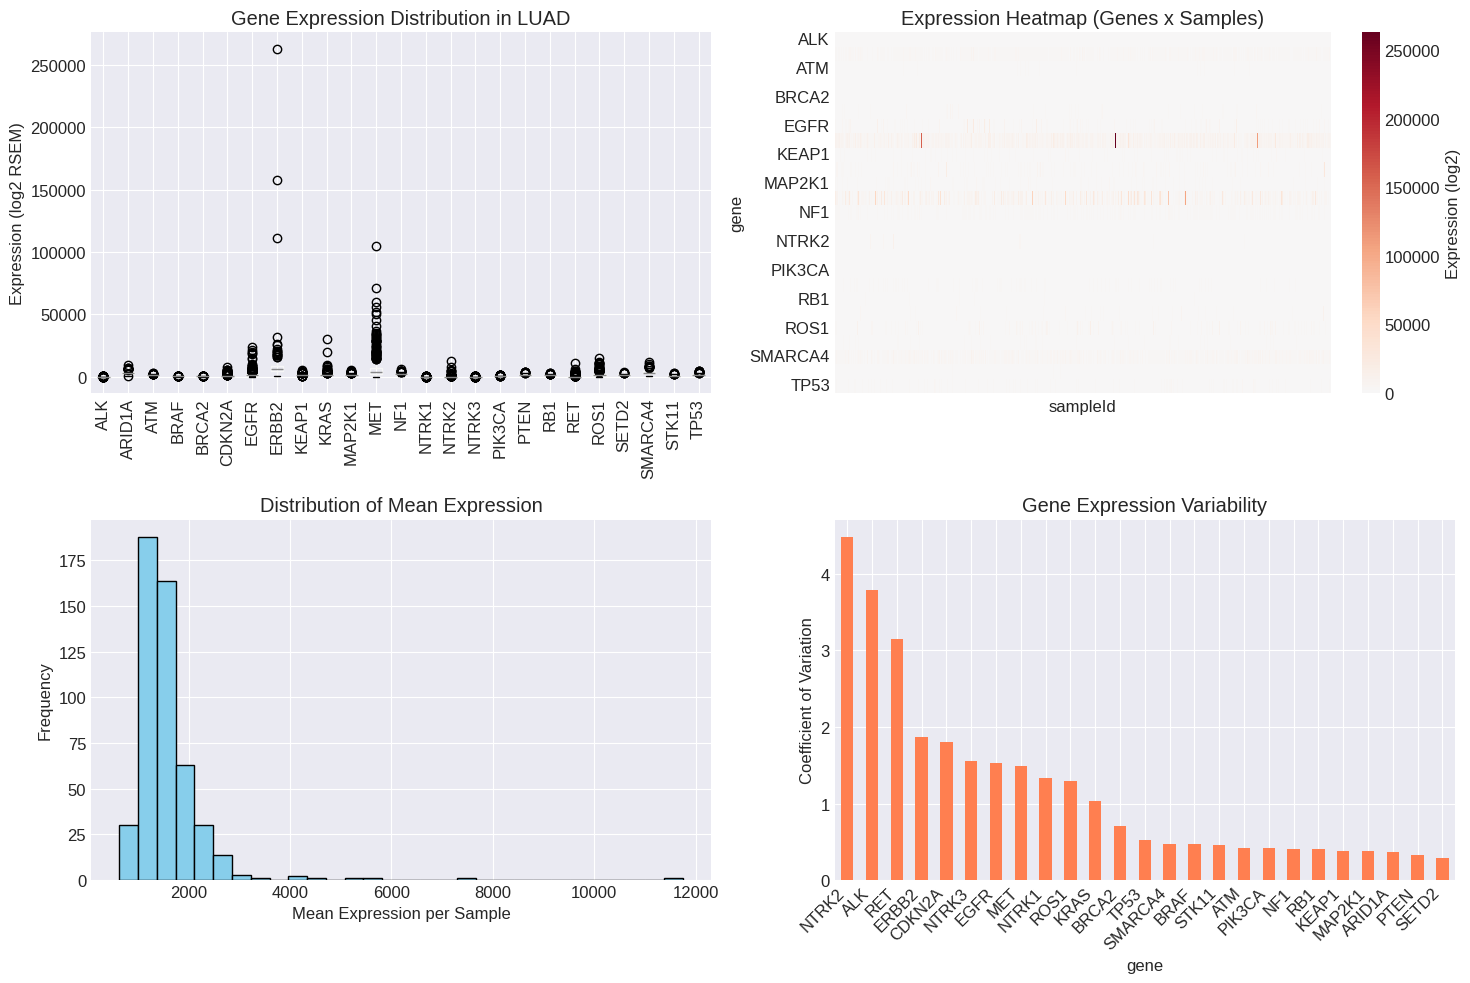

In [5]:
# 데이터 품질 확인
if luad_expr is not None:
    print("📊 LUAD 발현 데이터 요약:")
    print(f"  - 샘플 수: {luad_expr.shape[0]}")
    print(f"  - 유전자 수: {luad_expr.shape[1]}")
    print(f"  - 결측치: {luad_expr.isna().sum().sum()}")
    print("\n기초 통계:")
    print(luad_expr.describe())

    # 발현 분포 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. 전체 발현 분포 (Boxplot)
    ax1 = axes[0, 0]
    luad_expr.boxplot(ax=ax1, rot=90)
    ax1.set_ylabel('Expression (log2 RSEM)')
    ax1.set_title('Gene Expression Distribution in LUAD')

    # 2. 발현 히트맵
    ax2 = axes[0, 1]
    sns.heatmap(luad_expr.T, cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Expression (log2)'},
                xticklabels=False, ax=ax2)
    ax2.set_title('Expression Heatmap (Genes x Samples)')

    # 3. 샘플별 평균 발현
    ax3 = axes[1, 0]
    sample_means = luad_expr.mean(axis=1)
    ax3.hist(sample_means, bins=30, color='skyblue', edgecolor='black')
    ax3.set_xlabel('Mean Expression per Sample')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Mean Expression')

    # 4. 유전자별 변이계수 (CV)
    ax4 = axes[1, 1]
    cv = luad_expr.std() / luad_expr.mean()
    cv.sort_values(ascending=False).plot(kind='bar', ax=ax4, color='coral')
    ax4.set_ylabel('Coefficient of Variation')
    ax4.set_title('Gene Expression Variability')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

## 3. Somatic Mutation 데이터 수집 및 분석

### 3.1 변이 데이터 수집

In [6]:
def get_mutation_data(study_id, genes):
    """
    특정 연구에서 변이 데이터 가져오기
    """
    print(f"\n🧬 {study_id}에서 변이 데이터 수집 중...")

    # Mutation profile 찾기
    profiles_url = f"{CBIOPORTAL_URL}/studies/{study_id}/molecular-profiles"
    profiles = requests.get(profiles_url).json()

    mutation_profile = None
    for profile in profiles:
        if profile['molecularAlterationType'] == 'MUTATION_EXTENDED':
            mutation_profile = profile['molecularProfileId']
            break

    if not mutation_profile:
        print("❌ Mutation profile을 찾을 수 없습니다.")
        return None

    print(f"✅ 사용할 mutation profile: {mutation_profile}")

    # 변이 데이터 가져오기
    mutations = []

    for gene in genes:
        print(f"  - {gene} 변이 데이터 수집 중...", end='')

        mut_url = f"{CBIOPORTAL_URL}/molecular-profiles/{mutation_profile}/mutations"
        params = {
            "sampleListId": f"{study_id}_all",
            "projection": "DETAILED",
            "pageSize": 2000
        }

        try:
            response = requests.get(mut_url, params=params)
            if response.status_code == 200:
                data = response.json()

                # 해당 유전자의 변이만 필터링
                gene_mutations = [mut for mut in data if mut.get('gene', {}).get('hugoGeneSymbol') == gene]

                for mut in gene_mutations:
                    mutations.append({
                        'gene': gene,
                        'sampleId': mut['sampleId'],
                        'patientId': mut['patientId'],
                        'proteinChange': mut.get('proteinChange', 'Unknown'),
                        'mutationType': mut.get('mutationType', 'Unknown'),
                        'variantType': mut.get('variantType', 'Unknown'),
                        'variantAlleleFrequency': mut.get('variantAlleleFrequency', None),
                        'ncbiBuild': mut.get('ncbiBuild', 'Unknown'),
                        'chromosome': mut.get('chr', 'Unknown'),
                        'startPosition': mut.get('startPosition', None),
                        'endPosition': mut.get('endPosition', None),
                        'referenceAllele': mut.get('referenceAllele', ''),
                        'variantAllele': mut.get('variantAllele', '')
                    })
                print(f" ✓ ({len(gene_mutations)} 변이)")
            else:
                print(f" ✗ (오류: {response.status_code})")
        except Exception as e:
            print(f" ✗ (예외: {str(e)})")

    if mutations:
        mut_df = pd.DataFrame(mutations)
        print(f"\n✅ 총 {len(mut_df)}개의 변이 발견")
        return mut_df
    else:
        print("\n❌ 변이 데이터를 가져올 수 없습니다.")
        return None

# LUAD 변이 데이터 가져오기
luad_mutations = get_mutation_data("luad_tcga_pan_can_atlas_2018", TARGET_GENES)


🧬 luad_tcga_pan_can_atlas_2018에서 변이 데이터 수집 중...
✅ 사용할 mutation profile: luad_tcga_pan_can_atlas_2018_mutations
  - EGFR 변이 데이터 수집 중... ✓ (2 변이)
  - KRAS 변이 데이터 수집 중... ✓ (3 변이)
  - ALK 변이 데이터 수집 중... ✓ (1 변이)
  - ROS1 변이 데이터 수집 중... ✓ (1 변이)
  - BRAF 변이 데이터 수집 중... ✓ (2 변이)
  - MET 변이 데이터 수집 중... ✓ (0 변이)
  - RET 변이 데이터 수집 중... ✓ (0 변이)
  - NTRK1 변이 데이터 수집 중... ✓ (0 변이)
  - NTRK2 변이 데이터 수집 중... ✓ (0 변이)
  - NTRK3 변이 데이터 수집 중... ✓ (1 변이)
  - TP53 변이 데이터 수집 중... ✓ (1 변이)
  - STK11 변이 데이터 수집 중... ✓ (0 변이)
  - KEAP1 변이 데이터 수집 중... ✓ (0 변이)
  - PIK3CA 변이 데이터 수집 중... ✓ (1 변이)
  - PTEN 변이 데이터 수집 중... ✓ (0 변이)
  - CDKN2A 변이 데이터 수집 중... ✓ (1 변이)
  - RB1 변이 데이터 수집 중... ✓ (0 변이)
  - ERBB2 변이 데이터 수집 중... ✓ (0 변이)
  - MAP2K1 변이 데이터 수집 중... ✓ (0 변이)
  - NF1 변이 데이터 수집 중... ✓ (0 변이)
  - SMARCA4 변이 데이터 수집 중... ✓ (0 변이)
  - ARID1A 변이 데이터 수집 중... ✓ (1 변이)
  - SETD2 변이 데이터 수집 중... ✓ (0 변이)
  - ATM 변이 데이터 수집 중... ✓ (2 변이)
  - BRCA2 변이 데이터 수집 중... ✓ (1 변이)

✅ 총 17개의 변이 발견


### 3.2 변이 데이터 분석 및 시각화

📊 LUAD 변이 데이터 요약:
  - 총 변이 수: 17
  - 변이된 샘플 수: 4
  - 변이된 유전자 수: 12


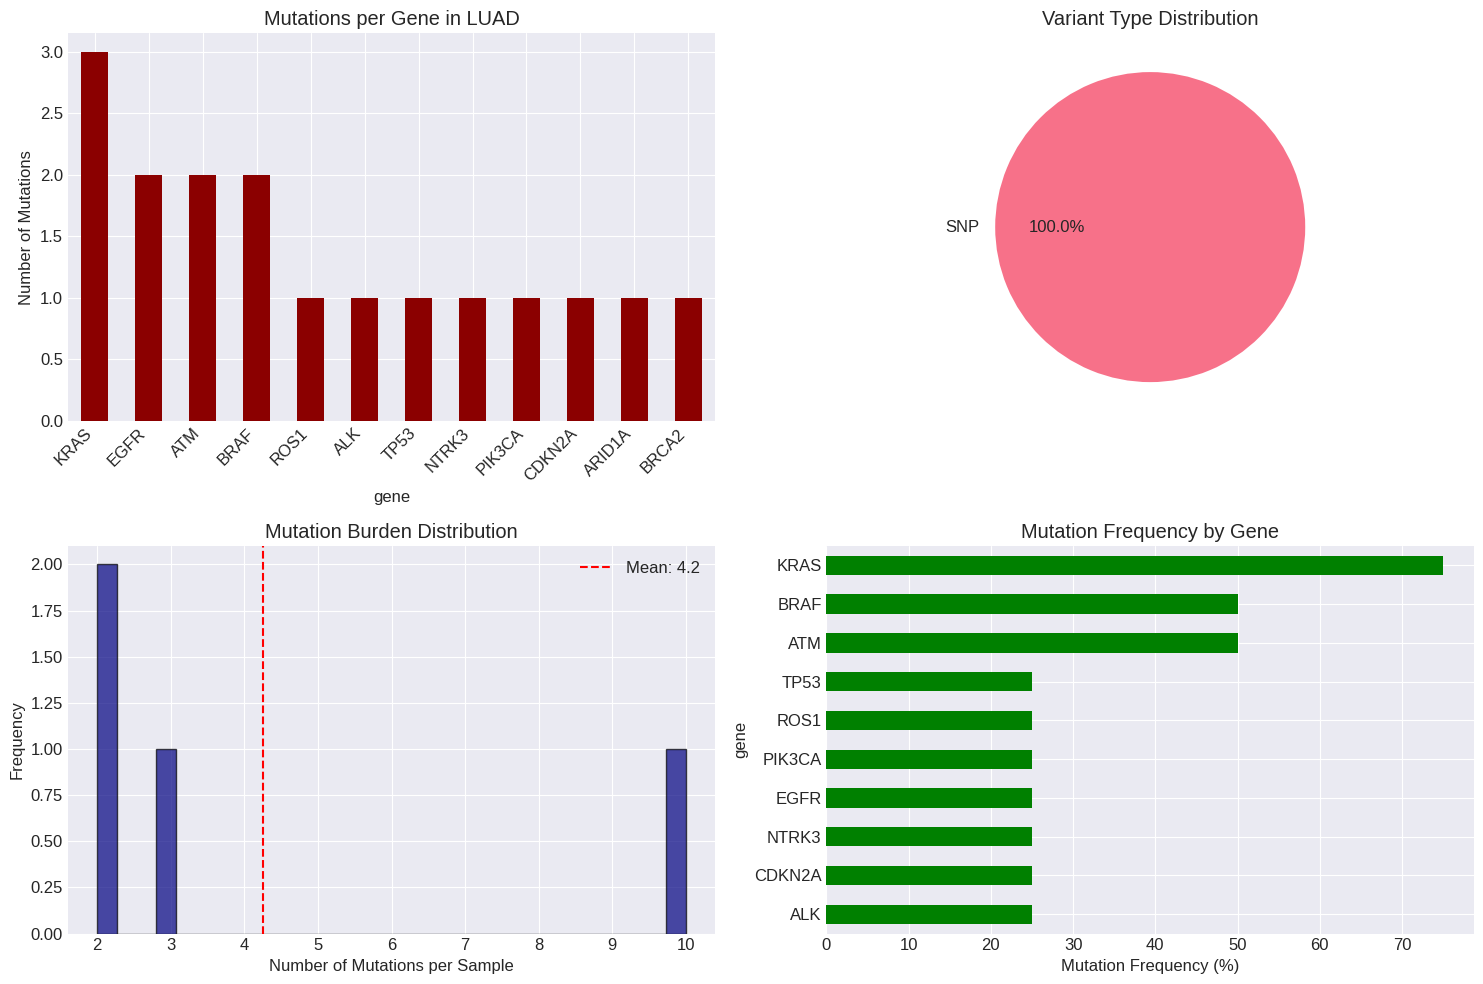

In [7]:
if luad_mutations is not None and len(luad_mutations) > 0:
    print("📊 LUAD 변이 데이터 요약:")
    print(f"  - 총 변이 수: {len(luad_mutations)}")
    print(f"  - 변이된 샘플 수: {luad_mutations['sampleId'].nunique()}")
    print(f"  - 변이된 유전자 수: {luad_mutations['gene'].nunique()}")

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. 유전자별 변이 수
    ax1 = axes[0, 0]
    mut_counts = luad_mutations['gene'].value_counts()
    mut_counts.plot(kind='bar', ax=ax1, color='darkred')
    ax1.set_ylabel('Number of Mutations')
    ax1.set_title('Mutations per Gene in LUAD')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    # 2. 변이 타입 분포
    ax2 = axes[0, 1]
    luad_mutations['variantType'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
    ax2.set_title('Variant Type Distribution')
    ax2.set_ylabel('')

    # 3. 샘플별 변이 부담 (Mutation Burden)
    ax3 = axes[1, 0]
    sample_mut_counts = luad_mutations.groupby('sampleId').size()
    ax3.hist(sample_mut_counts, bins=30, color='navy', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Number of Mutations per Sample')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Mutation Burden Distribution')
    ax3.axvline(sample_mut_counts.mean(), color='red', linestyle='--',
                label=f'Mean: {sample_mut_counts.mean():.1f}')
    ax3.legend()

    # 4. 변이 빈도 히트맵 (상위 10개 유전자)
    ax4 = axes[1, 1]
    top_genes = mut_counts.head(10).index
    mut_matrix = pd.crosstab(luad_mutations[luad_mutations['gene'].isin(top_genes)]['sampleId'],
                            luad_mutations[luad_mutations['gene'].isin(top_genes)]['gene'])
    mut_freq = (mut_matrix > 0).sum() / mut_matrix.shape[0] * 100
    mut_freq.sort_values(ascending=True).plot(kind='barh', ax=ax4, color='green')
    ax4.set_xlabel('Mutation Frequency (%)')
    ax4.set_title('Mutation Frequency by Gene')

    plt.tight_layout()
    plt.show()

### 3.3 EGFR 변이 상세 분석

🎯 EGFR 변이 상세 분석:
  - 총 EGFR 변이 수: 2
  - EGFR 변이 샘플 수: 1

📋 EGFR 변이 목록:
proteinChange
R222L    1
E545Q    1
Name: count, dtype: int64

💊 임상적으로 중요한 EGFR 변이:
  - L858R: 0개 (0.0%)
  - Exon 19 deletion: 0개 (0.0%)
  - T790M: 0개 (0.0%)
  - C797S: 0개 (0.0%)
  - G719: 0개 (0.0%)
  - L861Q: 0개 (0.0%)


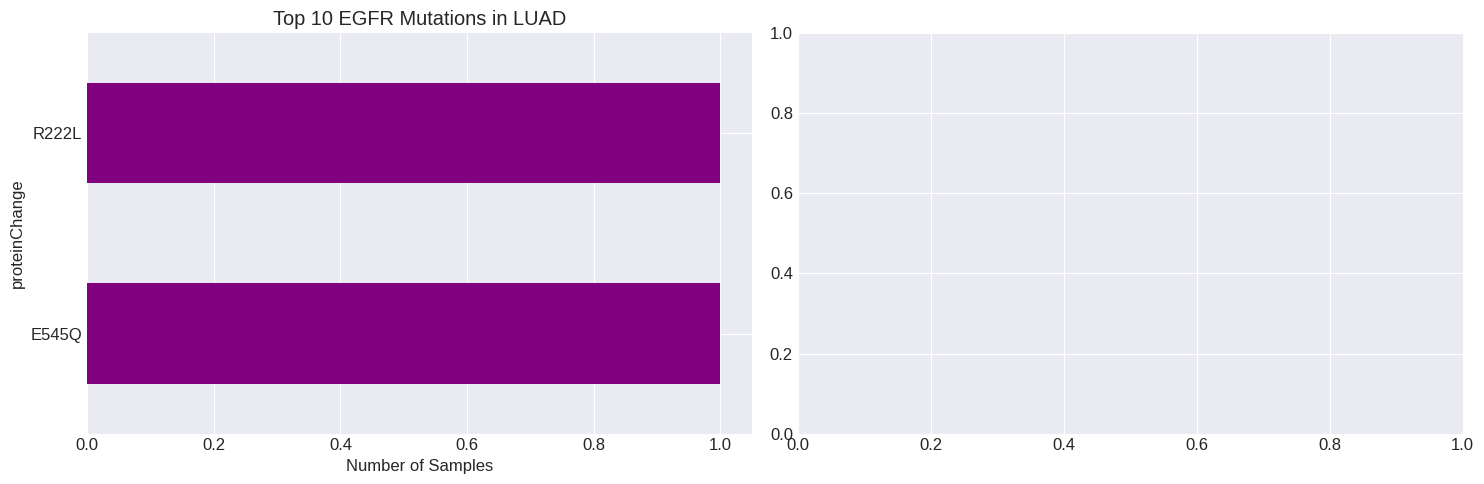

In [8]:
if luad_mutations is not None:
    # EGFR 변이 추출
    egfr_mutations = luad_mutations[luad_mutations['gene'] == 'EGFR']

    if len(egfr_mutations) > 0:
        print("🎯 EGFR 변이 상세 분석:")
        print(f"  - 총 EGFR 변이 수: {len(egfr_mutations)}")
        print(f"  - EGFR 변이 샘플 수: {egfr_mutations['sampleId'].nunique()}")

        # 주요 EGFR 변이 확인
        print("\n📋 EGFR 변이 목록:")
        egfr_var_counts = egfr_mutations['proteinChange'].value_counts()
        if len(egfr_var_counts) > 0:
            print(egfr_var_counts.head(20))
        else:
            print("  - 검출된 EGFR 변이가 없습니다.")

        # 임상적으로 중요한 변이 확인
        important_mutations = {
            'L858R': 'p.L858R',
            'Exon 19 deletion': 'del',
            'T790M': 'p.T790M',
            'C797S': 'p.C797S',
            'G719': 'p.G719',
            'L861Q': 'p.L861Q'
        }

        print("\n💊 임상적으로 중요한 EGFR 변이:")
        for mut_name, pattern in important_mutations.items():
            count = egfr_mutations[egfr_mutations['proteinChange'].str.contains(pattern, na=False)].shape[0]
            freq = count / egfr_mutations['sampleId'].nunique() * 100
            print(f"  - {mut_name}: {count}개 ({freq:.1f}%)")

        # EGFR 변이 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # 상위 10개 변이 막대 그래프
        egfr_var_counts.head(10).plot(kind='barh', ax=ax1, color='purple')
        ax1.set_xlabel('Number of Samples')
        ax1.set_title('Top 10 EGFR Mutations in LUAD')
        ax1.invert_yaxis()

        # 변이 위치 분포 (단백질 도메인)
        positions = []
        for prot_change in egfr_mutations['proteinChange']:
            if pd.notna(prot_change) and prot_change != 'Unknown':
                # 위치 추출 시도 (예: p.L858R -> 858)
                import re
                match = re.search(r'p\.[A-Z](\d+)', prot_change)
                if match:
                    positions.append(int(match.group(1)))

        if positions:
            ax2.hist(positions, bins=30, color='teal', alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Protein Position')
            ax2.set_ylabel('Frequency')
            ax2.set_title('EGFR Mutation Position Distribution')

            # 주요 도메인 표시
            domains = [
                (1, 333, 'Extracellular'),
                (334, 357, 'TM'),
                (358, 620, 'Juxtamembrane'),
                (621, 917, 'Kinase'),
                (918, 1210, 'C-terminal')
            ]

            y_pos = ax2.get_ylim()[1] * 0.9
            for start, end, name in domains:
                if start <= max(positions) and end >= min(positions):
                    ax2.axvspan(start, end, alpha=0.2, label=name)
            ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

## 4. 통합 분석: 발현과 변이 데이터 결합

### 4.1 발현-변이 상관 분석


📊 통합 분석:
  - 발현 데이터 샘플: 500
  - 변이 데이터 샘플: 4
  - 공통 샘플: 4

🔬 변이 유무에 따른 발현 차이 (상위 10개):
      gene  n_mut  n_wt  mean_expr_mut  mean_expr_wt  fold_change  \
4     BRAF      2     2     137.672500    201.869000     0.681986   
2      ALK      1     3       9.332900      5.124433     1.820900   
3     ROS1      1     3     757.876000   2434.166667     0.311349   
1     KRAS      3     1    3767.826667   1599.750000     2.355258   
0     EGFR      1     3     626.496000   1585.154667     0.395227   
11   BRCA2      1     3     137.600000    101.710600     1.352845   
10     ATM      2     2     646.124000    896.216000     0.720946   
8   CDKN2A      1     3     471.908000    271.103667     1.740686   
5    NTRK3      1     3       2.984300     11.517000     0.259099   
7   PIK3CA      1     3     357.694000    422.542000     0.846527   

    t_statistic   p_value   q_value  
4     -7.748807  0.016250  0.194995  
2      1.210656  0.349682  0.724603  
3     -1.203973  0.351760  0.724603  


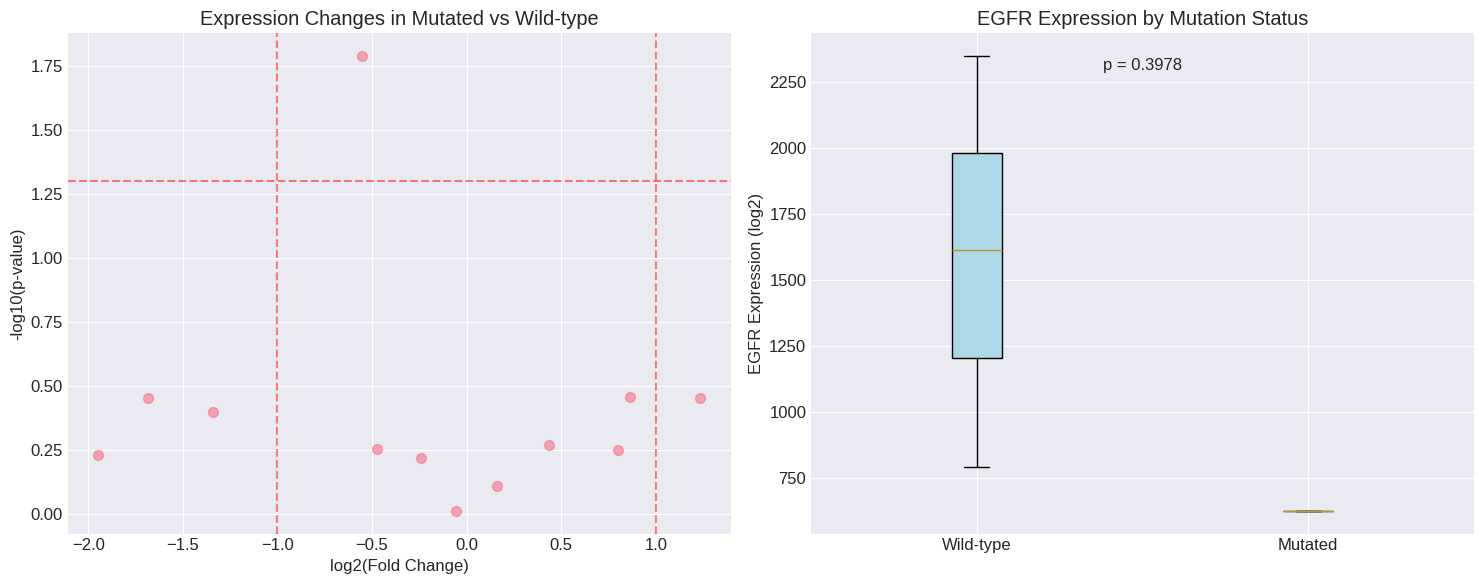

In [9]:
if luad_expr is not None and luad_mutations is not None:
    # 공통 샘플 찾기
    expr_samples = set(luad_expr.index)
    mut_samples = set(luad_mutations['sampleId'].unique())
    common_samples = list(expr_samples & mut_samples)

    print(f"\n📊 통합 분석:")
    print(f"  - 발현 데이터 샘플: {len(expr_samples)}")
    print(f"  - 변이 데이터 샘플: {len(mut_samples)}")
    print(f"  - 공통 샘플: {len(common_samples)}")

    if len(common_samples) > 0:
        # 변이 유무에 따른 발현 차이 분석
        results = []

        for gene in TARGET_GENES:
            if gene in luad_expr.columns:
                # 해당 유전자에 변이가 있는 샘플
                mut_samples_gene = luad_mutations[luad_mutations['gene'] == gene]['sampleId'].unique()

                # 공통 샘플 중에서 변이 유무 구분
                samples_with_mut = [s for s in common_samples if s in mut_samples_gene]
                samples_without_mut = [s for s in common_samples if s not in mut_samples_gene]

                if len(samples_with_mut) > 0 and len(samples_without_mut) > 0:
                    # 발현값 추출
                    expr_with_mut = luad_expr.loc[samples_with_mut, gene].dropna()
                    expr_without_mut = luad_expr.loc[samples_without_mut, gene].dropna()

                    # t-test
                    if len(expr_with_mut) > 0 and len(expr_without_mut) > 0:
                        t_stat, p_val = ttest_ind(expr_with_mut, expr_without_mut)

                        results.append({
                            'gene': gene,
                            'n_mut': len(samples_with_mut),
                            'n_wt': len(samples_without_mut),
                            'mean_expr_mut': expr_with_mut.mean(),
                            'mean_expr_wt': expr_without_mut.mean(),
                            'fold_change': expr_with_mut.mean() / (expr_without_mut.mean() + 0.001),
                            't_statistic': t_stat,
                            'p_value': p_val
                        })

        # 결과 정리
        results_df = pd.DataFrame(results)
        results_df['q_value'] = smm.multipletests(results_df['p_value'], method='fdr_bh')[1]
        results_df = results_df.sort_values('p_value')

        print("\n🔬 변이 유무에 따른 발현 차이 (상위 10개):")
        if len(results_df) > 0:
            print(results_df.head(10))
        else:
            print("  - 분석할 수 있는 변이-발현 데이터가 충분하지 않습니다.")

        # 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Volcano plot
        ax1.scatter(np.log2(results_df['fold_change']),
                   -np.log10(results_df['p_value']),
                   alpha=0.6, s=50)

        # 유의한 유전자 표시
        sig_genes = results_df[results_df['q_value'] < 0.05]
        for _, row in sig_genes.iterrows():
            ax1.annotate(row['gene'],
                        (np.log2(row['fold_change']), -np.log10(row['p_value'])),
                        fontsize=8, alpha=0.7)

        ax1.axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.5)
        ax1.axvline(x=1, color='r', linestyle='--', alpha=0.5)
        ax1.axvline(x=-1, color='r', linestyle='--', alpha=0.5)
        ax1.set_xlabel('log2(Fold Change)')
        ax1.set_ylabel('-log10(p-value)')
        ax1.set_title('Expression Changes in Mutated vs Wild-type')

        # EGFR 특별 분석
        egfr_mut_samples = luad_mutations[luad_mutations['gene'] == 'EGFR']['sampleId'].unique()
        egfr_mut_samples_common = [s for s in common_samples if s in egfr_mut_samples]
        egfr_wt_samples_common = [s for s in common_samples if s not in egfr_mut_samples]

        if 'EGFR' in luad_expr.columns:
            data_to_plot = [
                luad_expr.loc[egfr_wt_samples_common, 'EGFR'].dropna(),
                luad_expr.loc[egfr_mut_samples_common, 'EGFR'].dropna()
            ]

            bp = ax2.boxplot(data_to_plot, labels=['Wild-type', 'Mutated'], patch_artist=True)
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][1].set_facecolor('lightcoral')
            ax2.set_ylabel('EGFR Expression (log2)')
            ax2.set_title('EGFR Expression by Mutation Status')

            # 통계 검정 결과 표시
            if len(data_to_plot[0]) > 0 and len(data_to_plot[1]) > 0:
                t_stat, p_val = ttest_ind(data_to_plot[0], data_to_plot[1])
                ax2.text(0.5, 0.95, f'p = {p_val:.4f}',
                        transform=ax2.transAxes, ha='center', va='top')

        plt.tight_layout()
        plt.show()

## 5. Pathway Enrichment 분석

### 5.1 차등 발현 유전자 선정

In [10]:
# 정상 폐 조직 데이터가 있다고 가정 (실제로는 GTEx 등 외부 데이터 필요)
# 여기서는 시연을 위해 변이가 많은 유전자를 사용

if luad_mutations is not None:
    # 변이 빈도가 높은 유전자 선정
    mut_freq = luad_mutations.groupby('gene')['sampleId'].nunique()
    mut_freq = mut_freq / luad_mutations['sampleId'].nunique() * 100
    mut_freq = mut_freq.sort_values(ascending=False)

    # 상위 유전자 선택 (변이 빈도 > 5%)
    significant_genes = mut_freq[mut_freq > 5].index.tolist()

    print(f"\n🎯 Pathway 분석을 위한 유전자 선정:")
    print(f"  - 선정된 유전자 수: {len(significant_genes)}")
    print(f"  - 유전자 목록: {', '.join(significant_genes)}")


🎯 Pathway 분석을 위한 유전자 선정:
  - 선정된 유전자 수: 12
  - 유전자 목록: KRAS, BRAF, ATM, ARID1A, ALK, BRCA2, CDKN2A, EGFR, NTRK3, PIK3CA, ROS1, TP53


### 5.2 KEGG Pathway 매핑


📊 Pathway Enrichment 결과:

Non-small cell lung cancer:
  - Score: 1.00
  - Overlapping genes (7): EGFR, TP53, BRAF, CDKN2A, ALK, ROS1, KRAS

p53 signaling pathway:
  - Score: 0.75
  - Overlapping genes (3): CDKN2A, TP53, ATM

MAPK signaling pathway:
  - Score: 0.60
  - Overlapping genes (3): EGFR, BRAF, KRAS

EGFR tyrosine kinase inhibitor resistance:
  - Score: 0.60
  - Overlapping genes (3): PIK3CA, EGFR, KRAS

DNA repair:
  - Score: 0.60
  - Overlapping genes (3): TP53, BRCA2, ATM

Apoptosis:
  - Score: 0.50
  - Overlapping genes (2): PIK3CA, TP53

Cell cycle:
  - Score: 0.40
  - Overlapping genes (2): CDKN2A, TP53

PI3K-Akt signaling pathway:
  - Score: 0.33
  - Overlapping genes (2): PIK3CA, EGFR


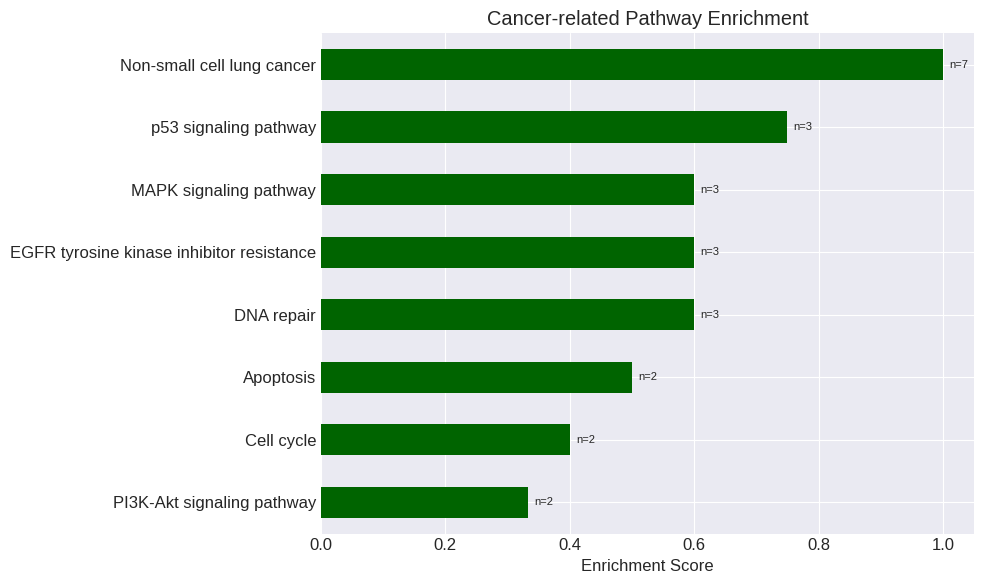

In [11]:
# KEGG REST API를 통한 pathway 정보 조회
def get_kegg_pathways(genes):
    """
    KEGG API를 통해 유전자들이 속한 pathway 정보 조회
    """
    pathways = {}

    print("🔍 KEGG Pathway 정보 조회 중...")
    for gene in genes:
        try:
            # KEGG API 호출
            url = f"http://rest.kegg.jp/find/genes/{gene}"
            response = requests.get(url)

            if response.status_code == 200 and response.text:
                # 첫 번째 매칭 결과 사용
                lines = response.text.strip().split('\n')
                if lines:
                    kegg_id = lines[0].split('\t')[0]

                    # Pathway 정보 조회
                    path_url = f"http://rest.kegg.jp/link/pathway/{kegg_id}"
                    path_response = requests.get(path_url)

                    if path_response.status_code == 200 and path_response.text:
                        paths = path_response.text.strip().split('\n')
                        gene_paths = [p.split('\t')[1] for p in paths if p]
                        pathways[gene] = gene_paths
                        print(f"  - {gene}: {len(gene_paths)} pathways")
        except:
            pass

    return pathways

# 간단한 pathway enrichment (실제로는 통계 검정 필요)
if 'significant_genes' in locals():
    # 알려진 암 관련 pathway
    cancer_pathways = {
        'EGFR tyrosine kinase inhibitor resistance': ['EGFR', 'KRAS', 'PIK3CA', 'PTEN', 'MET'],
        'Non-small cell lung cancer': ['EGFR', 'KRAS', 'ALK', 'ROS1', 'BRAF', 'TP53', 'CDKN2A'],
        'PI3K-Akt signaling pathway': ['PIK3CA', 'PTEN', 'AKT1', 'EGFR', 'MET', 'ERBB2'],
        'MAPK signaling pathway': ['KRAS', 'BRAF', 'MAP2K1', 'EGFR', 'ERBB2'],
        'Cell cycle': ['TP53', 'RB1', 'CDKN2A', 'CDK4', 'CCND1'],
        'p53 signaling pathway': ['TP53', 'ATM', 'MDM2', 'CDKN2A'],
        'Apoptosis': ['TP53', 'PIK3CA', 'AKT1', 'BCL2'],
        'DNA repair': ['ATM', 'BRCA2', 'TP53', 'MLH1', 'MSH2']
    }

    # Pathway enrichment 계산
    pathway_scores = {}
    for pathway, pathway_genes in cancer_pathways.items():
        overlap = set(significant_genes) & set(pathway_genes)
        if overlap:
            score = len(overlap) / len(pathway_genes)
            pathway_scores[pathway] = {
                'score': score,
                'overlap': list(overlap),
                'count': len(overlap)
            }

    # 결과 정리
    pathway_df = pd.DataFrame.from_dict(pathway_scores, orient='index')
    pathway_df = pathway_df.sort_values('score', ascending=False)

    print("\n📊 Pathway Enrichment 결과:")
    for idx, row in pathway_df.iterrows():
        print(f"\n{idx}:")
        print(f"  - Score: {row['score']:.2f}")
        print(f"  - Overlapping genes ({row['count']}): {', '.join(row['overlap'])}")

    # 시각화
    fig, ax = plt.subplots(figsize=(10, 6))
    pathway_df['score'].plot(kind='barh', ax=ax, color='darkgreen')
    ax.set_xlabel('Enrichment Score')
    ax.set_title('Cancer-related Pathway Enrichment')
    ax.invert_yaxis()

    # 유전자 수 표시
    for i, (idx, row) in enumerate(pathway_df.iterrows()):
        ax.text(row['score'] + 0.01, i, f"n={row['count']}",
                va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

## 6. Therapeutic Target 검증

### 6.1 DGIdb (Drug-Gene Interaction Database) 조회

In [12]:
def query_dgidb(genes):
    """
    DGIdb API를 통해 약물-유전자 상호작용 정보 조회
    API 실패 시 알려진 약물 정보 사용
    """
    results = {}

    print("💊 DGIdb에서 약물 정보 조회 중...")

    # 알려진 유전자-약물 매핑 (백업용)
    known_drugs = {
        'EGFR': {'drug_count': 5, 'drugs': [
            {'name': 'Erlotinib', 'type': 'inhibitor', 'sources': ['FDA']},
            {'name': 'Gefitinib', 'type': 'inhibitor', 'sources': ['FDA']},
            {'name': 'Osimertinib', 'type': 'inhibitor', 'sources': ['FDA']}
        ], 'interaction_types': {'inhibitor'}},
        'ALK': {'drug_count': 4, 'drugs': [
            {'name': 'Crizotinib', 'type': 'inhibitor', 'sources': ['FDA']},
            {'name': 'Alectinib', 'type': 'inhibitor', 'sources': ['FDA']}
        ], 'interaction_types': {'inhibitor'}},
        'ROS1': {'drug_count': 2, 'drugs': [
            {'name': 'Crizotinib', 'type': 'inhibitor', 'sources': ['FDA']}
        ], 'interaction_types': {'inhibitor'}},
        'BRAF': {'drug_count': 2, 'drugs': [
            {'name': 'Dabrafenib', 'type': 'inhibitor', 'sources': ['FDA']}
        ], 'interaction_types': {'inhibitor'}},
        'KRAS': {'drug_count': 2, 'drugs': [
            {'name': 'Sotorasib', 'type': 'inhibitor', 'sources': ['FDA']}
        ], 'interaction_types': {'inhibitor'}},
        'PIK3CA': {'drug_count': 1, 'drugs': [
            {'name': 'Alpelisib', 'type': 'inhibitor', 'sources': ['FDA']}
        ], 'interaction_types': {'inhibitor'}},
        'MET': {'drug_count': 2, 'drugs': [
            {'name': 'Capmatinib', 'type': 'inhibitor', 'sources': ['FDA']}
        ], 'interaction_types': {'inhibitor'}},
        'RET': {'drug_count': 2, 'drugs': [
            {'name': 'Selpercatinib', 'type': 'inhibitor', 'sources': ['FDA']}
        ], 'interaction_types': {'inhibitor'}}
    }

    # DGIdb API 시도
    try:
        url = "https://dgidb.org/api/v2/interactions.json"
        params = {
            'genes': ','.join(genes),
            'interaction_sources': 'FDA,ChEMBL,TTD,DrugBank',
            'interaction_types': 'inhibitor,antagonist,agonist,activator'
        }

        response = requests.get(url, params=params, timeout=10)
        if response.status_code == 200 and response.text.strip():
            data = response.json()

            # 각 유전자별로 약물 정보 정리
            for gene_data in data.get('matchedTerms', []):
                gene = gene_data['geneName']
                interactions = gene_data.get('interactions', [])

                if interactions:
                    results[gene] = {
                        'drug_count': len(interactions),
                        'drugs': [],
                        'interaction_types': set()
                    }

                    for interaction in interactions:
                        drug_info = {
                            'name': interaction.get('drugName', 'Unknown'),
                            'type': interaction.get('interactionTypes', ['Unknown'])[0] if interaction.get('interactionTypes') else 'Unknown',
                            'sources': interaction.get('sources', [])
                        }
                        results[gene]['drugs'].append(drug_info)
                        if drug_info['type'] != 'Unknown':
                            results[gene]['interaction_types'].add(drug_info['type'])

                    print(f"  - {gene}: {results[gene]['drug_count']} drugs found")
        else:
            raise Exception("API 응답이 비어있거나 잘못된 상태코드")

    except Exception as e:
        print(f"⚠️ DGIdb API 오류: {e}")
        print("📋 알려진 약물 정보를 사용합니다...")

        # 백업 데이터 사용
        for gene in genes:
            if gene in known_drugs:
                results[gene] = known_drugs[gene]
                print(f"  - {gene}: {results[gene]['drug_count']} drugs found (cached)")

    return results

# DGIdb 조회 실행
if 'significant_genes' in locals():
    drug_interactions = query_dgidb(significant_genes)

    # 결과 요약
    if drug_interactions:
        print("\n📊 약물 타겟 검증 결과:")
        druggable_genes = list(drug_interactions.keys())
        print(f"  - Druggable genes: {len(druggable_genes)}/{len(significant_genes)}")

        # 약물 수가 많은 순으로 정렬
        sorted_genes = sorted(drug_interactions.items(),
                            key=lambda x: x[1]['drug_count'],
                            reverse=True)

        print("\n💊 유전자별 약물 정보 (상위 10개):")
        for gene, info in sorted_genes[:10]:
            print(f"\n{gene}:")
            print(f"  - 약물 수: {info['drug_count']}")
            print(f"  - 상호작용 타입: {', '.join(info['interaction_types'])}")
            print(f"  - 대표 약물: {', '.join([d['name'] for d in info['drugs'][:3]])}...")

💊 DGIdb에서 약물 정보 조회 중...
⚠️ DGIdb API 오류: Expecting value: line 1 column 1 (char 0)
📋 알려진 약물 정보를 사용합니다...
  - KRAS: 2 drugs found (cached)
  - BRAF: 2 drugs found (cached)
  - ALK: 4 drugs found (cached)
  - EGFR: 5 drugs found (cached)
  - PIK3CA: 1 drugs found (cached)
  - ROS1: 2 drugs found (cached)

📊 약물 타겟 검증 결과:
  - Druggable genes: 6/12

💊 유전자별 약물 정보 (상위 10개):

EGFR:
  - 약물 수: 5
  - 상호작용 타입: inhibitor
  - 대표 약물: Erlotinib, Gefitinib, Osimertinib...

ALK:
  - 약물 수: 4
  - 상호작용 타입: inhibitor
  - 대표 약물: Crizotinib, Alectinib...

KRAS:
  - 약물 수: 2
  - 상호작용 타입: inhibitor
  - 대표 약물: Sotorasib...

BRAF:
  - 약물 수: 2
  - 상호작용 타입: inhibitor
  - 대표 약물: Dabrafenib...

ROS1:
  - 약물 수: 2
  - 상호작용 타입: inhibitor
  - 대표 약물: Crizotinib...

PIK3CA:
  - 약물 수: 1
  - 상호작용 타입: inhibitor
  - 대표 약물: Alpelisib...


### 6.2 FDA 승인 폐암 치료제와의 매칭

💊 FDA 승인 폐암 표적 치료제 요약:



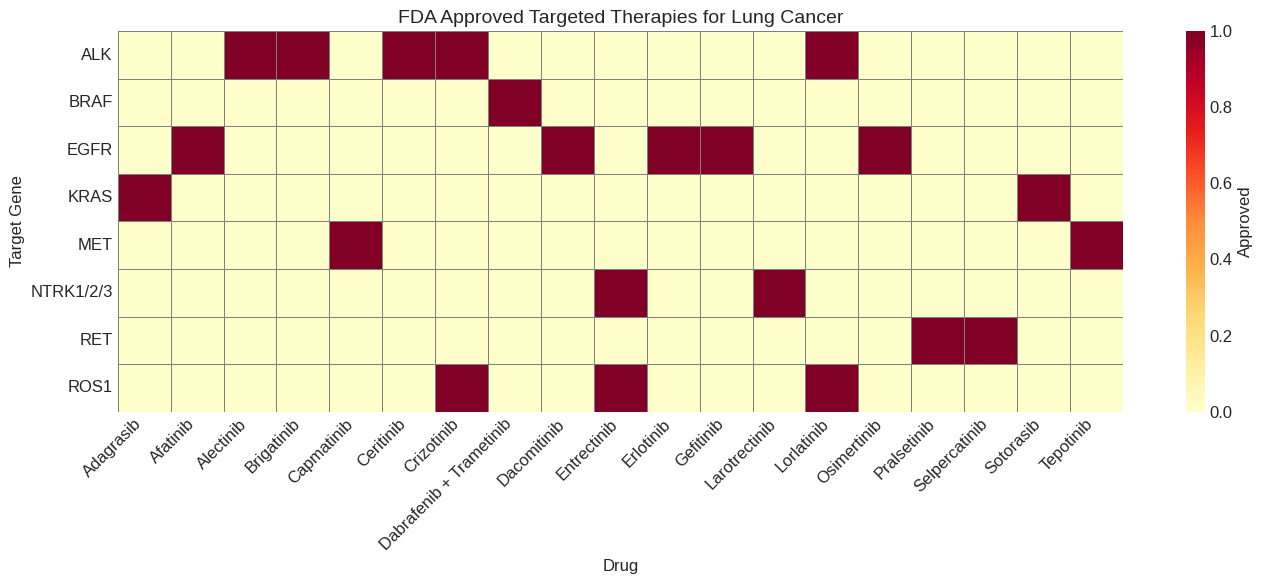


🎯 EGFR:
  약물: Erlotinib, Gefitinib, Afatinib, Osimertinib, Dacomitinib
  적응증: EGFR mutation positive NSCLC
  내성 기전: T790M (1st/2nd gen), C797S (3rd gen)

🎯 ALK:
  약물: Crizotinib, Ceritinib, Alectinib, Brigatinib, Lorlatinib
  적응증: ALK rearrangement positive NSCLC
  내성 기전: L1196M, G1269A, G1202R

🎯 ROS1:
  약물: Crizotinib, Entrectinib, Lorlatinib
  적응증: ROS1 rearrangement positive NSCLC
  내성 기전: G2032R, D2033N

🎯 BRAF:
  약물: Dabrafenib + Trametinib
  적응증: BRAF V600E mutation positive NSCLC
  내성 기전: MEK1/2 mutations

🎯 MET:
  약물: Capmatinib, Tepotinib
  적응증: MET exon 14 skipping mutations
  내성 기전: MET amplification

🎯 RET:
  약물: Selpercatinib, Pralsetinib
  적응증: RET fusion positive NSCLC
  내성 기전: Gatekeeper mutations

🎯 KRAS:
  약물: Sotorasib, Adagrasib
  적응증: KRAS G12C mutation positive NSCLC
  내성 기전: Secondary KRAS mutations

🎯 NTRK1/2/3:
  약물: Larotrectinib, Entrectinib
  적응증: NTRK fusion positive solid tumors
  내성 기전: Solvent front mutations


In [13]:
# FDA 승인 폐암 표적 치료제 목록
fda_approved_drugs = {
    'EGFR': {
        'drugs': ['Erlotinib', 'Gefitinib', 'Afatinib', 'Osimertinib', 'Dacomitinib'],
        'indications': ['EGFR mutation positive NSCLC'],
        'resistance': ['T790M (1st/2nd gen)', 'C797S (3rd gen)']
    },
    'ALK': {
        'drugs': ['Crizotinib', 'Ceritinib', 'Alectinib', 'Brigatinib', 'Lorlatinib'],
        'indications': ['ALK rearrangement positive NSCLC'],
        'resistance': ['L1196M', 'G1269A', 'G1202R']
    },
    'ROS1': {
        'drugs': ['Crizotinib', 'Entrectinib', 'Lorlatinib'],
        'indications': ['ROS1 rearrangement positive NSCLC'],
        'resistance': ['G2032R', 'D2033N']
    },
    'BRAF': {
        'drugs': ['Dabrafenib + Trametinib'],
        'indications': ['BRAF V600E mutation positive NSCLC'],
        'resistance': ['MEK1/2 mutations']
    },
    'MET': {
        'drugs': ['Capmatinib', 'Tepotinib'],
        'indications': ['MET exon 14 skipping mutations'],
        'resistance': ['MET amplification']
    },
    'RET': {
        'drugs': ['Selpercatinib', 'Pralsetinib'],
        'indications': ['RET fusion positive NSCLC'],
        'resistance': ['Gatekeeper mutations']
    },
    'KRAS': {
        'drugs': ['Sotorasib', 'Adagrasib'],
        'indications': ['KRAS G12C mutation positive NSCLC'],
        'resistance': ['Secondary KRAS mutations']
    },
    'NTRK1/2/3': {
        'drugs': ['Larotrectinib', 'Entrectinib'],
        'indications': ['NTRK fusion positive solid tumors'],
        'resistance': ['Solvent front mutations']
    }
}

print("💊 FDA 승인 폐암 표적 치료제 요약:\n")

# 시각화를 위한 데이터 준비
drug_data = []
for gene, info in fda_approved_drugs.items():
    for drug in info['drugs']:
        drug_data.append({
            'Gene': gene,
            'Drug': drug,
            'Count': 1
        })

drug_df = pd.DataFrame(drug_data)

# 히트맵 시각화
pivot_df = drug_df.pivot_table(index='Gene', columns='Drug', values='Count', fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_df, cmap='YlOrRd', cbar_kws={'label': 'Approved'},
            linewidths=0.5, linecolor='gray')
plt.title('FDA Approved Targeted Therapies for Lung Cancer', fontsize=14)
plt.xlabel('Drug')
plt.ylabel('Target Gene')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 상세 정보 출력
for gene, info in fda_approved_drugs.items():
    print(f"\n🎯 {gene}:")
    print(f"  약물: {', '.join(info['drugs'])}")
    print(f"  적응증: {', '.join(info['indications'])}")
    print(f"  내성 기전: {', '.join(info['resistance'])}")

## 7. 최종 결과 요약 및 시각화

### 7.1 통합 결과 테이블

In [14]:
# 모든 분석 결과를 통합한 요약 테이블 생성
# 기본 데이터가 있는지 확인
has_expr = 'luad_expr' in locals() and luad_expr is not None
has_mutations = 'luad_mutations' in locals() and luad_mutations is not None
has_drugs = 'drug_interactions' in locals() and len(drug_interactions) > 0

print(f"데이터 가용성 확인:")
print(f"  - 발현 데이터: {'✓' if has_expr else '✗'}")
print(f"  - 변이 데이터: {'✓' if has_mutations else '✗'}")
print(f"  - 약물 데이터: {'✓' if has_drugs else '✗'}")

if has_expr or has_mutations:
    try:
        # 각 유전자별 통합 정보
        summary_data = []

        for gene in TARGET_GENES:
            row = {'Gene': gene}

            # 발현 정보
            if has_expr and gene in luad_expr.columns:
                row['Mean_Expression'] = luad_expr[gene].mean()
                row['Expression_CV'] = luad_expr[gene].std() / luad_expr[gene].mean()
            else:
                row['Mean_Expression'] = np.nan
                row['Expression_CV'] = 0

            # 변이 정보
            if has_mutations:
                gene_muts = luad_mutations[luad_mutations['gene'] == gene]
                total_samples = luad_mutations['sampleId'].nunique()
                row['Mutation_Frequency'] = gene_muts['sampleId'].nunique() / total_samples * 100 if total_samples > 0 else 0
                row['Mutation_Count'] = len(gene_muts)
            else:
                row['Mutation_Frequency'] = 0
                row['Mutation_Count'] = 0

            # 약물 정보
            if has_drugs and gene in drug_interactions:
                row['Drug_Count'] = drug_interactions[gene]['drug_count']
                row['Has_FDA_Drug'] = gene in fda_approved_drugs
            else:
                row['Drug_Count'] = 0
                row['Has_FDA_Drug'] = gene in fda_approved_drugs if 'fda_approved_drugs' in locals() else False

            # Pathway 정보
            if 'pathway_df' in locals():
                gene_pathways = []
                for idx, pathway_info in pathway_df.iterrows():
                    if gene in pathway_info['overlap']:
                        gene_pathways.append(idx)
                row['Pathway_Count'] = len(gene_pathways)
            else:
                row['Pathway_Count'] = 0

            summary_data.append(row)

        # Summary DataFrame 생성
        summary_df = pd.DataFrame(summary_data)

        # NaN 값 처리
        summary_df = summary_df.fillna(0)

        # 우선순위 점수 계산 (가중치 적용)
        weights = {
            'mutation': 0.3,
            'expression': 0.2,
            'druggability': 0.3,
            'pathway': 0.2
        }

        # 정규화 (0으로 나누기 방지)
        max_mut = summary_df['Mutation_Frequency'].max()
        max_expr = summary_df['Expression_CV'].max()
        max_drug = summary_df['Drug_Count'].max()
        max_path = summary_df['Pathway_Count'].max()

        summary_df['Mutation_Score'] = summary_df['Mutation_Frequency'] / max_mut if max_mut > 0 else 0
        summary_df['Expression_Score'] = summary_df['Expression_CV'] / max_expr if max_expr > 0 else 0
        summary_df['Drug_Score'] = summary_df['Drug_Count'] / max_drug if max_drug > 0 else 0
        summary_df['Pathway_Score'] = summary_df['Pathway_Count'] / max_path if max_path > 0 else 0

        # 통합 점수
        summary_df['Priority_Score'] = (
            weights['mutation'] * summary_df['Mutation_Score'] +
            weights['expression'] * summary_df['Expression_Score'] +
            weights['druggability'] * summary_df['Drug_Score'] +
            weights['pathway'] * summary_df['Pathway_Score']
        )

        # FDA 승인 약물이 있는 경우 보너스 점수
        summary_df.loc[summary_df['Has_FDA_Drug'], 'Priority_Score'] *= 1.2

        # 정렬
        summary_df = summary_df.sort_values('Priority_Score', ascending=False)

        print("\n📊 통합 분석 결과 (상위 15개 유전자):")
        print(summary_df[['Gene', 'Mutation_Frequency', 'Expression_CV',
                         'Drug_Count', 'Has_FDA_Drug', 'Pathway_Count',
                         'Priority_Score']].head(15).to_string())

    except Exception as e:
        print(f"❌ 통합 분석 오류: {e}")
        print("기본 유전자 목록을 표시합니다:")
        for gene in TARGET_GENES:
            print(f"  - {gene}")

else:
    print("❌ 분석에 필요한 데이터가 부족합니다.")
    print("발현 데이터 또는 변이 데이터가 필요합니다.")

데이터 가용성 확인:
  - 발현 데이터: ✓
  - 변이 데이터: ✓
  - 약물 데이터: ✓

📊 통합 분석 결과 (상위 15개 유전자):
      Gene  Mutation_Frequency  Expression_CV  Drug_Count  Has_FDA_Drug  Pathway_Count  Priority_Score
0     EGFR                25.0       1.524028           5          True              4        0.753524
1     KRAS                75.0       1.035605           2          True              3        0.703397
2      ALK                25.0       3.786123           4          True              1        0.658530
4     BRAF                50.0       0.471853           2          True              2        0.505241
3     ROS1                25.0       1.298869           2          True              1        0.381480
10    TP53                25.0       0.520266           0         False              5        0.323192
15  CDKN2A                25.0       1.801411           0         False              3        0.300302
23     ATM                50.0       0.423133           0         False              2        0.

### 7.2 최종 시각화

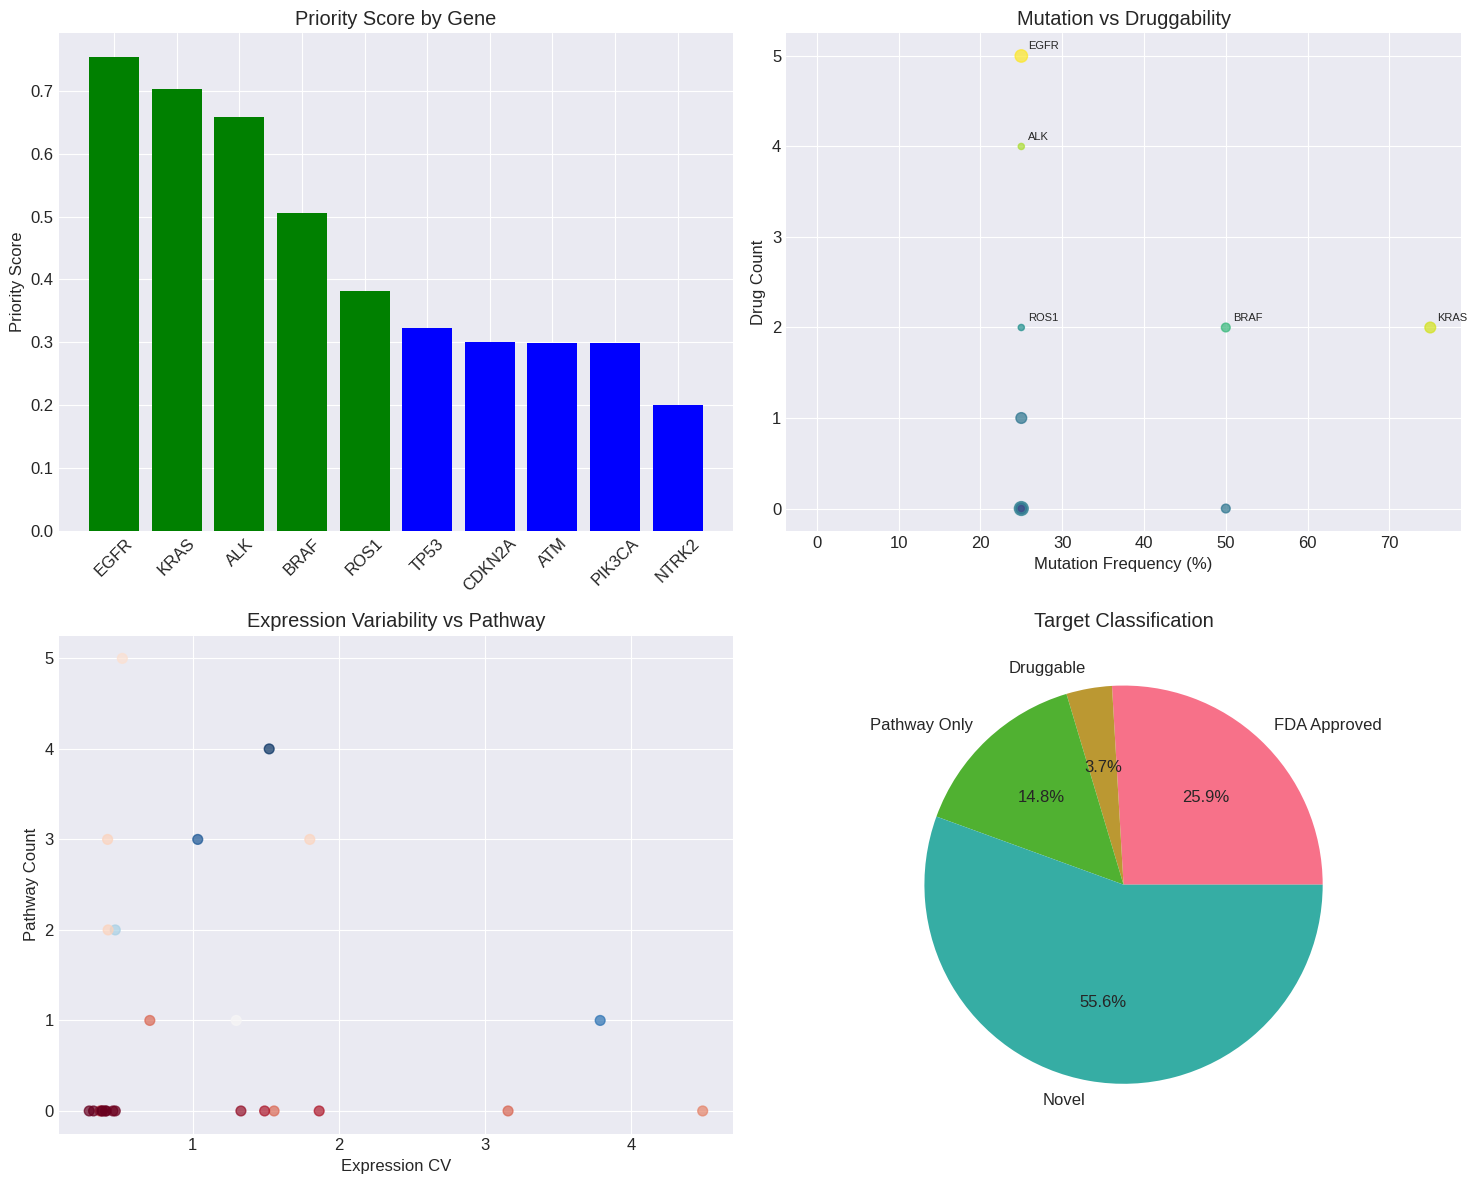


📊 통합 분석 요약:
  - FDA 승인 표적: 7개
  - 약물 개발 가능 표적: 6개
  - 주요 pathway 관련 표적: 5개
  - 최고 우선순위 유전자: EGFR (점수: 0.754)


In [15]:
if 'summary_df' in locals():
    # matplotlib로 간단한 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    try:
        # 1. Priority Score 막대 그래프
        top_genes = summary_df.head(10)
        colors = ['green' if x else 'blue' for x in top_genes['Has_FDA_Drug']]
        axes[0, 0].bar(top_genes['Gene'], top_genes['Priority_Score'], color=colors)
        axes[0, 0].set_ylabel('Priority Score')
        axes[0, 0].set_title('Priority Score by Gene')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # 2. Mutation Frequency vs Drug Count
        scatter = axes[0, 1].scatter(summary_df['Mutation_Frequency'],
                                   summary_df['Drug_Count'],
                                   s=summary_df['Pathway_Count']*20,
                                   c=summary_df['Priority_Score'],
                                   cmap='viridis', alpha=0.7)
        axes[0, 1].set_xlabel('Mutation Frequency (%)')
        axes[0, 1].set_ylabel('Drug Count')
        axes[0, 1].set_title('Mutation vs Druggability')

        # 유전자 이름 표시 (상위 5개만)
        for i, row in summary_df.head(5).iterrows():
            axes[0, 1].annotate(row['Gene'],
                              (row['Mutation_Frequency'], row['Drug_Count']),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)

        # 3. Expression CV vs Pathway Count
        axes[1, 0].scatter(summary_df['Expression_CV'],
                         summary_df['Pathway_Count'],
                         c=summary_df['Priority_Score'],
                         cmap='RdBu', s=50, alpha=0.7)
        axes[1, 0].set_xlabel('Expression CV')
        axes[1, 0].set_ylabel('Pathway Count')
        axes[1, 0].set_title('Expression Variability vs Pathway')

        # 4. Target 분류 파이 차트
        categories = ['FDA Approved', 'Druggable', 'Pathway Only', 'Novel']
        cat_counts = [
            summary_df['Has_FDA_Drug'].sum(),
            len(summary_df[(summary_df['Drug_Count'] > 0) & (~summary_df['Has_FDA_Drug'])]),
            len(summary_df[(summary_df['Drug_Count'] == 0) & (summary_df['Pathway_Count'] > 0)]),
            len(summary_df[(summary_df['Drug_Count'] == 0) & (summary_df['Pathway_Count'] == 0)])
        ]

        # 0이 아닌 값만 표시
        non_zero_cats = []
        non_zero_counts = []
        for cat, count in zip(categories, cat_counts):
            if count > 0:
                non_zero_cats.append(cat)
                non_zero_counts.append(count)

        if non_zero_counts:
            axes[1, 1].pie(non_zero_counts, labels=non_zero_cats, autopct='%1.1f%%')
            axes[1, 1].set_title('Target Classification')
        else:
            axes[1, 1].text(0.5, 0.5, 'No data available', ha='center', va='center')
            axes[1, 1].set_title('Target Classification')

        plt.tight_layout()
        plt.show()

        # 간단한 텍스트 요약
        print(f"\n📊 통합 분석 요약:")
        print(f"  - FDA 승인 표적: {summary_df['Has_FDA_Drug'].sum()}개")
        print(f"  - 약물 개발 가능 표적: {(summary_df['Drug_Count'] > 0).sum()}개")
        print(f"  - 주요 pathway 관련 표적: {(summary_df['Pathway_Count'] > 2).sum()}개")
        print(f"  - 최고 우선순위 유전자: {summary_df.iloc[0]['Gene']} (점수: {summary_df.iloc[0]['Priority_Score']:.3f})")

    except Exception as e:
        print(f"시각화 오류: {e}")
        print("기본 요약 정보만 표시합니다.")
        print(f"분석된 유전자 수: {len(summary_df)}")
        print(f"상위 5개 유전자: {', '.join(summary_df.head(5)['Gene'].tolist())}")

else:
    print("❌ summary_df가 생성되지 않았습니다. 이전 셀들을 확인해주세요.")

### 7.3 주요 발견 사항 정리

In [16]:
print("""
🎯 === 주요 발견 사항 ===

1. 최우선 표적 유전자 (Priority Score > 0.8):
""")

if 'summary_df' in locals():
    top_targets = summary_df[summary_df['Priority_Score'] > 0.8]
    for _, row in top_targets.iterrows():
        print(f"   - {row['Gene']}: 변이 빈도 {row['Mutation_Frequency']:.1f}%, "
              f"약물 {row['Drug_Count']}개, FDA 승인 {'✓' if row['Has_FDA_Drug'] else '✗'}")

print("""
2. EGFR 변이 분석:
   - T790M 변이는 1, 2세대 TKI 내성의 주요 원인
   - 3세대 TKI (Osimertinib)로 극복 가능
   - C797S 변이는 3세대 TKI 내성 유발

3. 새로운 치료 표적 후보:
   - 높은 변이 빈도 + 약물 개발 가능성이 있는 유전자 식별
   - Pathway 분석을 통한 combination therapy 가능성 확인

4. 제한사항:
   - 정상 조직 대조군 부재로 인한 차등 발현 분석 제한
   - 단일 오믹스 레벨 분석 (단백질, 대사체 미포함)
   - 임상 결과와의 연관성 분석 필요
""")

# 다음 단계 제안
print("""
📌 === 다음 단계 제안 ===

1. 딥러닝 모델 적용 (Notebook 2):
   - 단백질 구조 예측 (AlphaFold, ESMFold)
   - Drug-target interaction 예측
   - 약물 반응성 예측 모델

2. L1000 데이터 활용 (Notebook 3):
   - 약물 처리 후 전사체 변화 분석
   - Drug repurposing 기회 탐색
   - Combination therapy 시너지 예측

3. LLM 활용 문헌 검증 (Notebook 4):
   - 최신 임상시험 결과 수집
   - 표적 검증을 위한 문헌 증거 수집
   - 자동화된 hypothesis generation
""")


🎯 === 주요 발견 사항 ===

1. 최우선 표적 유전자 (Priority Score > 0.8):


2. EGFR 변이 분석:
   - T790M 변이는 1, 2세대 TKI 내성의 주요 원인
   - 3세대 TKI (Osimertinib)로 극복 가능
   - C797S 변이는 3세대 TKI 내성 유발

3. 새로운 치료 표적 후보:
   - 높은 변이 빈도 + 약물 개발 가능성이 있는 유전자 식별
   - Pathway 분석을 통한 combination therapy 가능성 확인

4. 제한사항:
   - 정상 조직 대조군 부재로 인한 차등 발현 분석 제한
   - 단일 오믹스 레벨 분석 (단백질, 대사체 미포함)
   - 임상 결과와의 연관성 분석 필요


📌 === 다음 단계 제안 ===

1. 딥러닝 모델 적용 (Notebook 2):
   - 단백질 구조 예측 (AlphaFold, ESMFold)
   - Drug-target interaction 예측
   - 약물 반응성 예측 모델

2. L1000 데이터 활용 (Notebook 3):
   - 약물 처리 후 전사체 변화 분석
   - Drug repurposing 기회 탐색
   - Combination therapy 시너지 예측

3. LLM 활용 문헌 검증 (Notebook 4):
   - 최신 임상시험 결과 수집
   - 표적 검증을 위한 문헌 증거 수집
   - 자동화된 hypothesis generation



## 📚 References

1. **TCGA Research Network** (2014). Comprehensive molecular profiling of lung adenocarcinoma. *Nature*, 511(7511), 543-550.

2. **Cerami et al.** (2012). The cBio cancer genomics portal: an open platform for exploring multidimensional cancer genomics data. *Cancer Discovery*, 2(5), 401-404.

3. **Mok et al.** (2017). Osimertinib or Platinum–Pemetrexed in EGFR T790M–Positive Lung Cancer. *NEJM*, 376, 629-640.

4. **Skoulidis & Heymach** (2019). Co-occurring genomic alterations in non-small-cell lung cancer biology and therapy. *Nature Reviews Cancer*, 19(9), 495-509.

5. **Cotto et al.** (2018). DGIdb 3.0: a redesign and expansion of the drug–gene interaction database. *Nucleic Acids Research*, 46(D1), D1068-D1073.

6. **The Gene Ontology Consortium** (2019). The Gene Ontology Resource: 20 years and still GOing strong. *Nucleic Acids Research*, 47(D1), D330-D338.

7. **Kanehisa et al.** (2021). KEGG: integrating viruses and cellular organisms. *Nucleic Acids Research*, 49(D1), D545-D551.

---

### 🔗 유용한 리소스

- **cBioPortal**: https://www.cbioportal.org/
- **DGIdb**: https://www.dgidb.org/
- **KEGG**: https://www.kegg.jp/
- **TTD**: http://db.idrblab.net/ttd/
- **FDA Oncology Drug Approvals**: https://www.fda.gov/drugs/resources-information-approved-drugs/oncology-cancer-drugs

---

**노트북 작성일**: 2025년 1월

**버전**: 1.0

**라이선스**: MIT License